In [ ]:
import numpy as np
import pandas as pd
import catboost as cat
import xgboost as xgb
import lightgbm as lgb
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, root_mean_squared_error

In [32]:
datasets_path = glob.glob(r'..\data\*.csv')

csv_files = {
    path.split("\\")[-1][:-4]: path
    for path in datasets_path
}

In [86]:
df = pd.read_csv(csv_files['dehliclimate'])
features = ['humidity', 'wind_speed', 'meanpressure']
val_size = len(df) - 50

x_train = df[features][:val_size]
y_train = df['meantemp'][:val_size]
x_val = df[features][val_size:]
y_val = df['meantemp'][val_size:]


In [51]:
x_train

,humidity,wind_speed,meanpressure
0,84.500000,0.000000,1015.666667
1,92.000000,2.980000,1017.800000
2,87.000000,4.633333,1018.666667
3,71.333333,1.233333,1017.166667
4,86.833333,3.700000,1016.500000
...,...,...,...
1407,52.269231,12.750000,1013.640000
1408,49.703704,7.074074,1014.666667
1409,50.148148,3.225926,1013.814815
1410,54.040000,2.968000,1014.080000


RMSE = 4.665873911889874


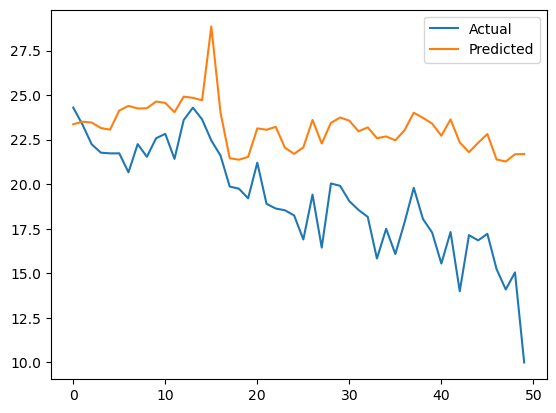

In [ ]:
evaldata = cat.Pool(x_val,y_val)
model = cat.CatBoostRegressor(iterations= 500 
                              ,task_type = "CPU"	
                              ,learning_rate=0.001
                              ,depth=6
                              ,verbose=0 
                              ,loss_function='RMSE')


model.fit(x_train, y_train, eval_set=[evaldata], early_stopping_rounds=100)

y_pred = model.predict(x_val)

cat_rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"RMSE = {cat_rmse)}")

y_val = y_val.reset_index(drop=True)
plt.plot(y_val, label = "Actual")
plt.plot(y_pred, label = "Predicted")
plt.legend()

In [113]:
model_xgb = xgb.XGBRegressor(n_estimators = 1000
                         ,learning_rate = 0.05
                         ,eval_metric='rmse'
                         ,early_stopping_rounds= 50)

model_xgb.fit(x_train,y_train,  eval_set=[(x_val, y_val)],verbose=100)

y_pred_xgb = model_xgb.predict(x_val)

[0]	validation_0-rmse:6.83900


[81]	validation_0-rmse:3.29526


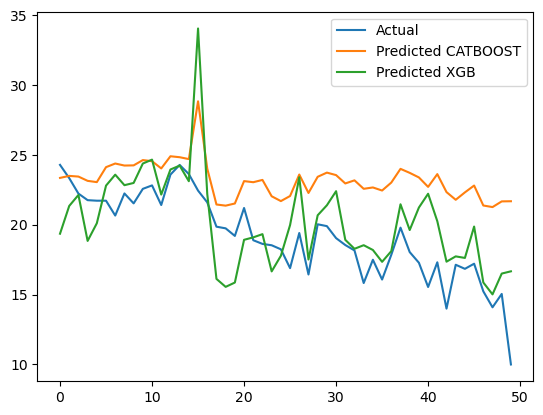

In [114]:
plt.plot(y_val, label = "Actual")
plt.plot(y_pred, label = "Predicted CATBOOST")
plt.plot(y_pred_xgb, label = "Predicted XGB")
plt.legend()

In [44]:
df.drop(columns=['date','meantemp']).columns

Index(['humidity', 'wind_speed', 'meanpressure'], dtype='object')